# Step 0. Code Modules, Links and Helpful Functions
#### [📑 GitHub Repository](https://github.com/OlgaBelitskaya/deep_learning_projects/tree/master/DL_PP2) & [📑 Colaboratory](https://colab.research.google.com/drive/1Z9Fz0OOi6bpWvH-H2OhExC9CkGPWBYZz)
#### [📑 Full Version - Python](https://olgabelitskaya.github.io/kaggle_letters.html) & [📑 Full Version - R](https://olgabelitskaya.github.io/kaggle_letters_R.html) 
#### [📑 Deep Learning. P2: Multi-Label Classification. Letter Recognition](https://olgabelitskaya.github.io/DL_PP2_Solutions_SMC.html)

In [1]:
import warnings; warnings.filterwarnings('ignore')
import numpy as np,pandas as pd,pylab as pl,h5py
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from IPython import display
from keras.preprocessing import image as ksimage
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping
from keras.metrics import top_k_categorical_accuracy,categorical_accuracy
from keras.models import Sequential,load_model,Model
from keras.layers import Dense,LSTM,GlobalAveragePooling1D,GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU,LeakyReLU
from keras.layers import Input,Activation,Flatten,Dropout,BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,GlobalMaxPooling2D
fw='weights.best.letters.hdf5'

Using TensorFlow backend.


In [2]:
# plotting of fitting histories for neural networks
def history_plot2(fit_history):
    keys=list(fit_history.history.keys())[6:]
    pl.figure(figsize=(12,10)); pl.subplot(211)
    pl.plot(fit_history.history[keys[0]],
            color='slategray',label='valid 1')
    pl.plot(fit_history.history[keys[1]],
            color='#4876ff',label='valid 2')
    pl.xlabel("Epochs"); pl.ylabel("Loss")
    pl.legend(); pl.grid(); pl.title('Loss Function')     
    pl.subplot(212)
    pl.plot(fit_history.history[keys[2]],
            color='slategray',label='valid 1')
    pl.plot(fit_history.history[keys[3]],
            color='#4876ff',label='valid 2')
    pl.xlabel("Epochs"); pl.ylabel("Accuracy")    
    pl.legend(); pl.grid(); pl.title('Accuracy'); pl.show()
# preprocessing functions 
def ohe(x): 
    return OneHotEncoder(categories='auto')\
           .fit(x.reshape(-1,1)).transform(x.reshape(-1,1))\
           .toarray().astype('int64')
def tts(X,y): 
    x_train,x_test,y_train,y_test=\
    train_test_split(X,y,test_size=.2,random_state=1)
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    return x_train,x_valid,x_test,y_train,y_valid,y_test

# ✒️ Step 1. Loading and Preprocessing the Data

In [3]:
f=h5py.File('../input/LetterColorImages_123.h5','r')
keys=list(f.keys()); keys

['backgrounds', 'images', 'labels']

In [4]:
# creating image arrays and targets
letters=u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
backgrounds=np.array(f[keys[0]])
labels=np.array(f[keys[2]])
# normalization of image arrays
images=np.array(f[keys[1]])/255

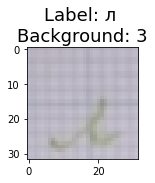

In [5]:
pl.figure(figsize=(2,3)); il=10**4
pl.title('Label: %s \n'%letters[labels[il]-1]+\
         'Background: %s'%backgrounds[il],
         fontsize=18)
pl.imshow(images[il]); pl.show()

In [6]:
# one-hot encoding
cbackgrounds,clabels=ohe(backgrounds),ohe(labels)
ctargets=np.concatenate((clabels,cbackgrounds),axis=1)
display.display(pd.DataFrame([labels[97:103],clabels[97:103]]).T)
pd.DataFrame([clabels.shape,cbackgrounds.shape,ctargets.shape])

,0,1
0,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,3,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


,0,1
0,14190,33
1,14190,4
2,14190,37


In [7]:
# splitting the data
x_train,x_valid,x_test,\
y_train,y_valid,y_test=tts(images,ctargets)

In [8]:
y_train_list=[y_train[:,:33],y_train[:,33:]]
y_test_list=[y_test[:,:33],y_test[:,33:]]
y_valid_list=[y_valid[:,:33],y_valid[:,33:]]

# ✒️ Step 2. Defining a Multi-Label Classification Model

In [9]:
def multi_model():   
    model_input=Input(shape=(32,32,3))
    x=BatchNormalization()(model_input)    
    x=Conv2D(32,(5,5),padding='same')(model_input)
    x=LeakyReLU(alpha=.02)(x)
    x=MaxPooling2D(pool_size=(2,2))(x)    
    x=Dropout(.25)(x)    
    x=Conv2D(256,(5,5),padding='same')(x)  
    x=LeakyReLU(alpha=.02)(x)
    x=MaxPooling2D(pool_size=(2,2))(x)    
    x=Dropout(.25)(x)              
    x=GlobalMaxPooling2D()(x)   
    x=Dense(1024)(x) 
    x=LeakyReLU(alpha=.02)(x)
    x=Dropout(.25)(x)       
    y1=Dense(33,activation='softmax')(x)
    y2=Dense(4,activation='softmax')(x)    
    model=Model(inputs=model_input,outputs=[y1,y2])
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])
    return model
multi_model=multi_model()

In [10]:
multi_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 32, 32, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 32)   0           leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

In [11]:
checkpointer=ModelCheckpoint(filepath=fw,verbose=2,save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=2,factor=.75)
estopping=EarlyStopping(monitor='val_loss',patience=20,verbose=2)
history=multi_model.fit(x_train,y_train_list,
                        epochs=200,batch_size=64,verbose=2,
                        validation_data=(x_valid,y_valid_list),
                        callbacks=[checkpointer,lr_reduction,estopping])

Train on 11352 samples, validate on 1419 samples
Epoch 1/200
 - 40s - loss: 4.2802 - dense_2_loss: 3.4689 - dense_3_loss: 0.8105 - dense_2_accuracy: 0.0386 - dense_3_accuracy: 0.6904 - val_loss: 4.0699 - val_dense_2_loss: 3.4085 - val_dense_3_loss: 0.6574 - val_dense_2_accuracy: 0.0437 - val_dense_3_accuracy: 0.8041

Epoch 00001: val_loss improved from inf to 4.06991, saving model to weights.best.letters.hdf5
Epoch 2/200
 - 40s - loss: 3.8537 - dense_2_loss: 3.2977 - dense_3_loss: 0.5548 - dense_2_accuracy: 0.0675 - dense_3_accuracy: 0.8197 - val_loss: 3.7036 - val_dense_2_loss: 3.2186 - val_dense_3_loss: 0.4757 - val_dense_2_accuracy: 0.0888 - val_dense_3_accuracy: 0.8584

Epoch 00002: val_loss improved from 4.06991 to 3.70365, saving model to weights.best.letters.hdf5
Epoch 3/200
 - 40s - loss: 3.5354 - dense_2_loss: 3.0994 - dense_3_loss: 0.4353 - dense_2_accuracy: 0.0936 - dense_3_accuracy: 0.8510 - val_loss: 3.4119 - val_dense_2_loss: 3.0233 - val_dense_3_loss: 0.3774 - val_dense_

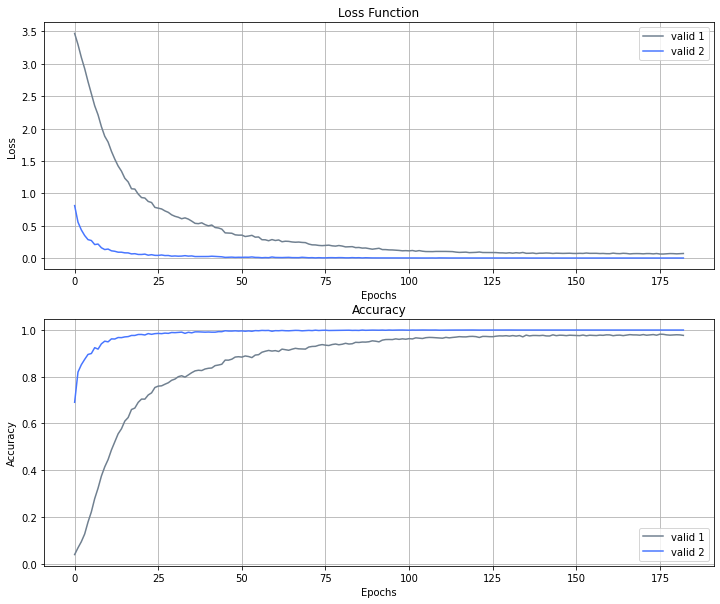

1419/1419 [==============================] - 1s 895us/step


[0.2481482377337519,
 0.2289080023765564,
 0.016620635986328125,
 0.9274136424064636,
 0.9957716464996338]

In [12]:
history_plot2(history)
# loading the model weights with the best validation accuracy
multi_model.load_weights(fw)
multi_model.evaluate(x_test,y_test_list)